# In this Notebook...
All kinds of early data operations on FoodBoost datasets

# Imports

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
#Load datasets
ingr = pd.read_csv('/data/foodboost/ingredients.csv', index_col=0)
nutr = pd.read_csv('/data/foodboost/nutritions.csv', index_col=0)
recp = pd.read_csv('/data/foodboost/recipes.csv', index_col=0)
tags = pd.read_csv('/data/foodboost/tags.csv', index_col=0)
nutr.head()

,recipe,nutrition,value
0,Kruidnoten met choco-discodip,energie,260 kcal
1,Kruidnoten met choco-discodip,koolhydraten,34 g
2,Kruidnoten met choco-discodip,waarvan suikers,22 g
3,Kruidnoten met choco-discodip,natrium,200 mg
4,Kruidnoten met choco-discodip,eiwit,3 g


# Data Research: Nutrients

In [15]:
#split the nutrients dataset to have datasets with only one nutrient
nutr_cal = nutr.loc[nutr['nutrition'] == 'energie']
nutr_eiw = nutr.loc[nutr['nutrition'] == 'eiwit']
nutr_kol = nutr.loc[nutr['nutrition'] == 'koolhydraten']
nutr_sui = nutr.loc[nutr['nutrition'] == 'waarvan suikers']
nutr_nat = nutr.loc[nutr['nutrition'] == 'natrium']
nutr_vet = nutr.loc[nutr['nutrition'] == 'vet']
nutr_zad = nutr.loc[nutr['nutrition'] == 'waarvan verzadigd']
nutr_vez = nutr.loc[nutr['nutrition'] == 'vezels']
nutr_cal.head()

,recipe,nutrition,value
0,Kruidnoten met choco-discodip,energie,260 kcal
8,Kruidnoten in marsepein,energie,265 kcal
16,Kruidnoten met chocodips,energie,335 kcal
24,Pepernotentaart met marsepeinstrik,energie,560 kcal
32,Perencake,energie,265 kcal


In [16]:
#merge the datasets together to have all nutrients of a recipe in same row
nutr_new = pd.merge(nutr_cal, nutr_eiw[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe', suffixes = ('_calorieën','_eiwitten'))
nutr_new.fillna('0 g', inplace=True)
nutr_new = pd.merge(nutr_new, nutr_kol[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe')
nutr_new.fillna('0 g', inplace=True)
nutr_new = pd.merge(nutr_new, nutr_sui[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe', suffixes = ('_koolhydraten','_suikers'))
nutr_new.fillna('0 g', inplace=True)
nutr_new = pd.merge(nutr_new, nutr_nat[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe')
nutr_new.fillna('0 mg', inplace=True)
nutr_new = pd.merge(nutr_new, nutr_vet[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe', suffixes = ('_natrium','_vet'))
nutr_new.fillna('0 g', inplace=True)
nutr_new = pd.merge(nutr_new, nutr_zad[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe')
nutr_new.fillna('0 g', inplace=True)
nutr_new = pd.merge(nutr_new, nutr_vez[['recipe', 'value']], how = 'outer', left_on = 'recipe', right_on = 'recipe', suffixes = ('_verzadigd','_vezels'))
nutr_new.fillna('0 g', inplace=True)

#remove units to have all nutrients be int or float
nutr_new['calorieën'] = nutr_new['value_calorieën'].map(lambda x: int(x.rstrip(' kcal')))
nutr_new['eiwitten'] = nutr_new['value_eiwitten'].map(lambda x: float(x.rstrip(' g')))
nutr_new['koolhydraten'] = nutr_new['value_koolhydraten'].map(lambda x: float(x.rstrip(' g')))
nutr_new['suikers'] = nutr_new['value_suikers'].map(lambda x: float(x.rstrip(' g')))
#distribute by 1000 to have mg to g
nutr_new['natrium'] = nutr_new['value_natrium'].map(lambda x: float(x.rstrip(' mg')))/1000
nutr_new['vet'] = nutr_new['value_vet'].map(lambda x: float(x.rstrip(' g')))
nutr_new['verzadigd'] = nutr_new['value_verzadigd'].map(lambda x: float(x.rstrip(' g')))
nutr_new['vezels'] = nutr_new['value_vezels'].map(lambda x: float(x.rstrip(' g')))
nutr_new = nutr_new.drop(columns=['value_calorieën', 'value_eiwitten', 'value_koolhydraten','value_suikers','value_natrium','value_vet','value_verzadigd','value_vezels','nutrition'])

#simulate wether recipe does or does not contain nuts
nutr_new['WelofGeenNoot?'] = np.random.randint(0, 2, nutr_new.shape[0])
nutr_new['index'] = nutr_new.index
nutr_new.head()

,recipe,calorieën,eiwitten,koolhydraten,suikers,natrium,vet,verzadigd,vezels,WelofGeenNoot?,index
0,Kruidnoten met choco-discodip,260,3.0,34.0,22.0,0.20,12.0,7.0,1.0,1,0
1,Kruidnoten in marsepein,265,3.0,43.0,34.0,0.12,9.0,4.0,1.0,1,1
2,Kruidnoten met chocodips,335,5.0,35.0,23.0,0.16,18.0,10.0,6.0,1,2
3,Pepernotentaart met marsepeinstrik,560,5.0,60.0,39.0,0.24,33.0,21.0,1.0,0,3
4,Perencake,265,5.0,36.0,21.0,0.12,11.0,2.0,1.0,1,4


# Data Research: Lunch and Diner String Data

In [31]:
#put all ingredients of recipe in one string
ingr['all_ingredients'] = ingr[['recipe', 'ingredient']].groupby(['recipe'])['ingredient'].transform(lambda x: '|'.join(x))
recp_ingr = ingr.copy()
recp_ingr = recp_ingr[['recipe', 'all_ingredients']]
recp_ingr.drop_duplicates(inplace=True, ignore_index=True)

#put all tags of recipe in one string
tags['all_tags'] = tags[['recipe', 'tag']].groupby(['recipe'])['tag'].transform(lambda x: '|'.join(x))
recp_tags = tags.copy()
recp_tags = recp_tags[['recipe','all_tags']]
recp_tags.drop_duplicates(inplace=True, ignore_index=True)

#merge the two dataframes together
recp_all = pd.merge(recp_ingr, recp_tags[["recipe","all_tags"]] , how= 'outer', left_on='recipe', right_on='recipe')

#only keep recipes where tags contain 'lunch', 'diner' or 'hoofdgerecht'
recp_Lunch = recp_all[recp_all['all_tags'].str.contains('lunch', na=False)]
recp_Diner = recp_all[recp_all['all_tags'].str.contains('diner', na=False)]
recp_HG = recp_all[recp_all['all_tags'].str.contains('hoofdgerecht', na=False)]
recp_Avond = pd.concat([recp_Diner,recp_HG],axis=0).drop_duplicates().reset_index(drop=True)
recp_Avond.head()

,recipe,all_ingredients,all_tags
0,Viscurry met spinazie en kikkererwten,arachideolie|wilde spinazie|ui|verse gember|ga...,lactosevrij|glutenvrij|slank|aziatisch|rijst|d...
1,Thaise scholspiesjes met kruidige rijst en wor...,pandanrijst|bosui|gele paprika|verse scholfile...,thais|aziatisch|diner|hoofdgerecht|wat eten we...
2,Gebakken scholfilet met lauwwarme rijstsalade,middelgroot ei|ui|bleekselderij|ongezouten roo...,mediterraan|rijst|diner|hoofdgerecht|wat eten ...
3,Gegrilde scholfilet met couscous-venkelsalade,4-granencouscous|ongebrande hazelnoten|venkelk...,mediterraan|salade|diner|hoofdgerecht|grillen
4,Gnocchi met spek en pecorino,ambachtelijk gerookt ontbijtspek|snoepgroente ...,snel|italiaans|pasta|diner|hoofdgerecht|wat et...


# Data Research: Pivot Tables

In [32]:
#Pivot table to show every ingredient and wether lunch contains it
ingr_tag = pd.merge(ingr, tags[["recipe","tag"]] , how= 'outer', left_on='recipe', right_on='recipe')
ingr_lunch = ingr_tag[ingr_tag['tag'].str.contains('lunch', na=False)]

ingr_lunch_pivot = ingr_lunch.pivot_table(values="recipe", index= ingr_lunch.recipe, columns=["ingredient"], aggfunc="count", fill_value=0)

ingr_lunch_pivot.head()

ingredient,(arachide)olie,(olijf)olie,(scharrel)braadworst,(wilde) perzik,(witte) quinoa,100% pindakaas met stukjes pinda's,3-kleurenquinoa,"30+ belegen kaas, in plakken",30+ kaas,5 spices,...,zuurdesembrood San Francisco,zuurdesemstarter,zuurkool naturel,zwart sesamzaad,zwarte bonen,zwarte bonen in blik,zwarte olijven,zwarte olijven zonder pit,zwarte peper,zwarte-peperkorrel
recipe,,,,,,,,,,,,,,,,,,,,,
&amp;Suus’ buik-weg-salade,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Indische' gehaktballetjes met zoete saus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'The day after'-ontbijt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2x gazpacho,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3 tosti's met graskaas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
#Pivot table to show every ingredient and wether diner contains it
ingr_tag = pd.merge(ingr, tags[["recipe","tag"]] , how= 'outer', left_on='recipe', right_on='recipe')
ingr_diner = ingr_tag[ingr_tag['tag'].str.contains('diner', na=False)]
ingr_hg = ingr_tag[ingr_tag['tag'].str.contains('hoofdgerecht', na=False)]
ingr_avond = pd.concat([ingr_diner,ingr_hg],axis=0).drop_duplicates().reset_index(drop=True)

ingr_avond_pivot = ingr_avond.pivot_table(values="recipe", index= ingr_avond.recipe, columns=["ingredient"], aggfunc="count", fill_value=0)

ingr_avond_pivot.head()

ingredient,(arachide)olie,(herten)biefstukken,(houdbare) melk,(magere) shoarmareepjes,(olijf)olie,(scharrel)braadworst,(wilde) perzik,(witte) quinoa,(wittewijn)azijn,(zonnebloem)olie,...,zwarte peperkorrels,zwarte quinoa,zwarte rijst,zwarte sesamzaadje,zwarte tagliatelle,zwarte-peperkorrel,zwarte-peperkorrels,zwarteolijvenplakjes,zwartepeperkorrel,zwijnsteak
recipe,,,,,,,,,,,,,,,,,,,,,
Andijviestamppot met gebakken salami,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Libanese wraps met appel-koolsalade,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plaattaart met gegrilde groenten en witte kaas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zalmspies met sojaglaze van de BBQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
'Burrito'-schotel met knapperige tortillapuntjes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#Every ingredient of both lunches and diners
ingr_both = pd.concat([ingr_avond,ingr_lunch],axis=0).drop_duplicates().reset_index(drop=True)

ingr_both_pivot = ingr_both.pivot_table(values="recipe", index= ingr_both.recipe, columns=["ingredient"], aggfunc="count", fill_value=0)

ingr_both_pivot.head()

ingredient,(arachide)olie,(herten)biefstukken,(houdbare) melk,(magere) shoarmareepjes,(olijf)olie,(scharrel)braadworst,(wilde) perzik,(witte) quinoa,(wittewijn)azijn,(zonnebloem)olie,...,zwarte peperkorrels,zwarte quinoa,zwarte rijst,zwarte sesamzaadje,zwarte tagliatelle,zwarte-peperkorrel,zwarte-peperkorrels,zwarteolijvenplakjes,zwartepeperkorrel,zwijnsteak
recipe,,,,,,,,,,,,,,,,,,,,,
Andijviestamppot met gebakken salami,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Libanese wraps met appel-koolsalade,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plaattaart met gegrilde groenten en witte kaas,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Zalmspies met sojaglaze van de BBQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
&amp;Suus’ buik-weg-salade,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Data Research: Cuisines

In [4]:
#load datasets
tagsa = pd.read_csv('/data/foodboost/tags.csv')
df = pd.read_csv("Modified Datasets/ingr_pivot_lunch_diner_noten.csv").set_index("recipe")

#remove ingredients that appear 40 or less times
ValidColumns = df.loc[:,df.sum() > 40][df.sum(axis=1) != 0]

#add tags and only keep the ones that appear more than 20 times
recepten = list(df.columns)
tagsb = tagsa[tagsa['recipe'].str.contains('|'.join(recepten))]
tags_pivot = tagsb.pivot_table(values="recipe", index= tagsb.recipe, columns="tag", aggfunc="count")
tags_pivot= tags_pivot.fillna(0) 
tags_ValidColumns = tags_pivot.loc[:,tags_pivot.sum() > 20][tags_pivot.sum(axis=1) != 0]
tags_ValidColumns.head()

/tmp/ipykernel_14338/2670951497.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  tagsb = tagsa[tagsa['recipe'].str.contains('|'.join(recepten))]


tag,5-ingrediënten,amerikaans,aziatisch,bakken,barbecue,bijgerecht,biologisch,borrel,borrelhapje,brood/sandwiches,...,veganistisch,vegetarisch,verjaardag,vooraf te maken,voorgerecht,wat eten we vandaag,wrap,zonder vlees,zonder vlees/vis,zuid-amerikaans
recipe,,,,,,,,,,,,,,,,,,,,,
Andijviestamppot met gebakken salami,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Bietensoep met selderijroom,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
Libanese wraps met appel-koolsalade,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
Plaattaart met gegrilde groenten en witte kaas,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
Sticky cauliflower (gegrilde bloemkoolroosjes) van Jord Althuizen,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#select cuisines from tags and give the recipes their respective cuisine
keukens = ['amerikaans','aziatisch','chinees','engels','frans','grieks','hollands','indiaas','indonesisch','italiaans', 'japans','marokkaans','mediterraan', 'mexicaans', 'midden-oosters','scandinavisch','spaans','thais','zuid-amerikaans']
df1 = tags_ValidColumns[keukens]
df1["sum"] = df1[keukens].sum(axis = 1)
df1=df1[df1["sum"] == 1]

tags2 = tagsb[tagsb['tag'].str.contains('|'.join(keukens))]
recepten_1_tag = list(df1.index)
tags2 = tags2[tags2['recipe'].isin(recepten_1_tag)]
tags2 = tags2.iloc[:,1:]
tags2.sort_values('recipe').head()

/tmp/ipykernel_14338/3475961855.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["sum"] = df1[keukens].sum(axis = 1)


,recipe,tag
31841,Andijviestamppot met gebakken salami,hollands
13996,'Burrito'-schotel met knapperige tortillapuntjes,zuid-amerikaans
108,'Kapsalon' met&nbsp;vegetarische&nbsp;kipshoar...,hollands
39543,'Pho' met mihoen en ribeye,aziatisch
20439,'Spaanse' surf &amp; turfspiesjes met pittige ...,spaans
...,...,...
42961,Zweedse balletjes,scandinavisch
40502,Zweedse broodsalade,scandinavisch
45948,Zweedse gehaktballetjes,scandinavisch
25071,Zweedse gehaktballetjes met room,scandinavisch


In [13]:
#create frequency dataframe
tagfreq = tags2['tag'].value_counts().rename_axis('keukens').reset_index(name = 'frequency')
tagfreq

,keukens,frequency
0,italiaans,793
1,hollands,626
2,aziatisch,370
3,mediterraan,252
4,frans,194
5,mexicaans,169
6,amerikaans,105
7,midden-oosters,93
8,spaans,53
9,engels,48


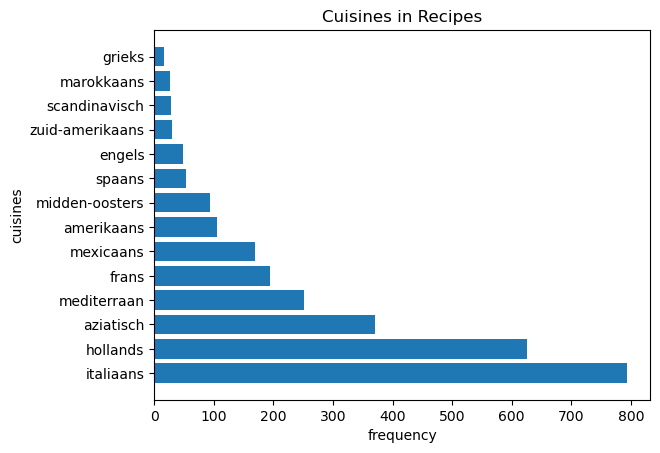

In [17]:
#plot the cuisine bar plot
k= tagfreq['keukens']
f= tagfreq['frequency']

plt.title('Cuisines in Recipes')
plt.xlabel('frequency')
plt.ylabel('cuisines')
plt.barh(k, f)
plt.savefig('hbarplotcuisines.png',dpi=300)
plt.show()

In [18]:
#Have both cuisine and ingredients show for each recipe
df_minder = df.loc[:,df.sum() > 40][df.sum(axis=1) != 0]
df_final = pd.merge(tags2, df_minder, how= 'inner',left_on= 'recipe', right_on = 'recipe')
df_final.head()

,recipe,tag,(arachide)olie,(olijf)olie,Franse mosterd,Griekse yoghurt,Japanse sojasaus,Parmezaanse kaas,Parmigiano Reggiano,Pecorino Romano (kaas),...,water,winterpeen,witlof,witte kaas 45+,witte rijst,zilvervliesrijst,zoete aardappel,zoete chilisaus,zonnebloemolie,zout
0,Pasta pesto met kipstuckjes en tomatensalade,italiaans,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Hutspot met vegetarische rookworst en jus,hollands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Zoete aardappelstamppot met spruiten en vega g...,hollands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,'Kapsalon' met&nbsp;vegetarische&nbsp;kipshoar...,hollands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gebakken krieltjes met broccoli en vegetarisch...,hollands,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
